In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Import Statsmodels
from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import adfuller
from statsmodels.tools.eval_measures import rmse, aic
name = '4_H12'

df = pd.read_csv('EURUSD_'+name+'_hazirVeri_yeni.csv', parse_dates=['Date'], index_col=0)
print(df.shape)  # (123, 8)
df.tail()

(11943, 5)


,Date,Open,High,Low,Close
11938,2021-12-22 12:00:00,1.12827,1.13423,1.12812,1.13258
11939,2021-12-23 00:00:00,1.13246,1.13422,1.13106,1.13207
11940,2021-12-23 12:00:00,1.13204,1.13378,1.12902,1.13263
11941,2021-12-24 00:00:00,1.13260,1.13415,1.13044,1.13405
11942,2021-12-24 12:00:00,1.13405,1.13435,1.13062,1.13197


In [2]:
df['Date'] = pd.to_numeric(pd.to_datetime(df['Date']))
from statsmodels.tsa.stattools import grangercausalitytests
maxlag=12
test = 'ssr_chi2test'
def grangers_causation_matrix(data, variables, test='ssr_chi2test', verbose=False):    
    """Check Granger Causality of all possible combinations of the Time series.
    The rows are the response variable, columns are predictors. The values in the table 
    are the P-Values. P-Values lesser than the significance level (0.05), implies 
    the Null Hypothesis that the coefficients of the corresponding past values is 
    zero, that is, the X does not cause Y can be rejected.

    data      : pandas dataframe containing the time series variables
    variables : list containing names of the time series variables.
    """
    df = pd.DataFrame(np.zeros((len(variables), len(variables))), columns=variables, index=variables)
    for c in df.columns:
        for r in df.index:
            test_result = grangercausalitytests(data[[r, c]], maxlag=maxlag, verbose=False)
            p_values = [round(test_result[i+1][0][test][1],4) for i in range(maxlag)]
            if verbose: print(f'Y = {r}, X = {c}, P Values = {p_values}')
            min_p_value = np.min(p_values)
            df.loc[r, c] = min_p_value
    df.columns = [var + '_x' for var in variables]
    df.index = [var + '_y' for var in variables]
    return df


C:\Users\ertad\miniconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:590: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'


            Date_2d   Open_2d   High_2d    Low_2d  Close_2d       Date_1d  \
11939  4.410654e+13 -0.000168 -0.000849  0.001356  0.000299  8.730654e+13   
11940  8.650071e+13 -0.000009 -0.000079 -0.000064 -0.000082  1.738072e+14   
11941  7.579278e+13 -0.000005 -0.000008 -0.000159 -0.000109  2.496000e+14   
11942  6.785301e+13 -0.000051 -0.000058 -0.000064 -0.000048  3.174530e+14   

       Date_forecast   Open_1d  Open_forecast   High_1d  High_forecast  \
11939   1.640262e+18 -0.000098       1.128172  0.003971       1.138201   
11940   1.640436e+18 -0.000108       1.128064  0.003892       1.142093   
11941   1.640685e+18 -0.000112       1.127952  0.003884       1.145977   
11942   1.641003e+18 -0.000164       1.127788  0.003826       1.149804   

         Low_1d  Low_forecast  Close_1d  Close_forecast  
11939  0.003056      1.131176  0.004619        1.137199  
11940  0.002992      1.134168  0.004537        1.141736  
11941  0.002833      1.137001  0.004429        1.146165  
11942  0.00

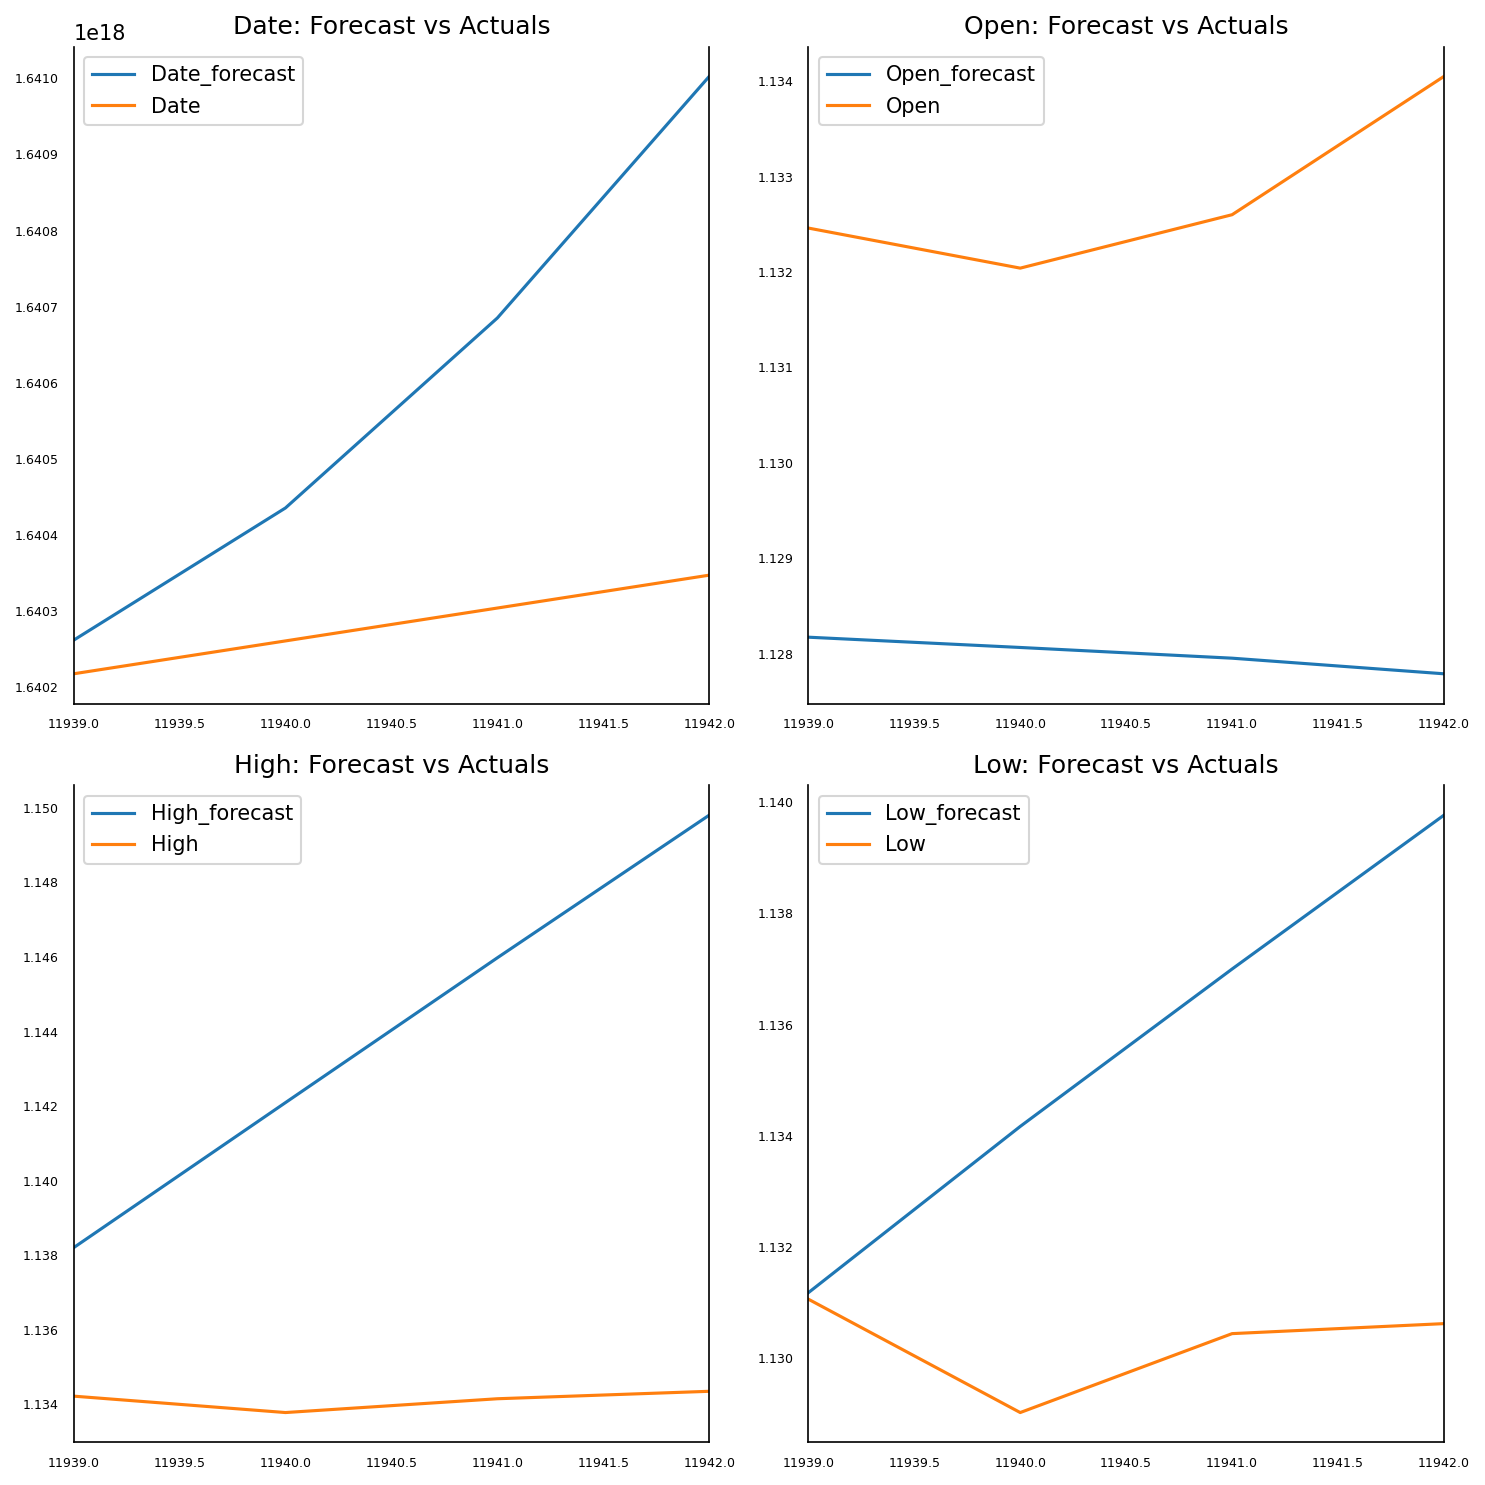

In [3]:
from statsmodels.tsa.vector_ar.vecm import coint_johansen
def adjust(val, length= 6): return str(val).ljust(length)
def cointegration_test(df, alpha=0.05): 
    """Perform Johanson's Cointegration Test and Report Summary"""
    out = coint_johansen(df,-1,5)
    d = {'0.90':0, '0.95':1, '0.99':2}
    traces = out.lr1
    cvts = out.cvt[:, d[str(1-alpha)]]
   

    # Summary
    #print('Name   ::  Test Stat > C(95%)    =>   Signif  \n', '--'*20)
    #for col, trace, cvt in zip(df.columns, traces, cvts):
        #print(adjust(col), ':: ', adjust(round(trace,2), 9), ">", adjust(cvt, 8), ' =>  ' , trace > cvt)

cointegration_test(df)


#############

nobs = 4
df_train, df_test = df[0:-nobs], df[-nobs:]

# Check size
#print(df_train.shape)  # (119, 8)
#print(df_test.shape)  # (4, 8)


############################

def adfuller_test(series, signif=0.05, name='', verbose=False):
    """Perform ADFuller to test for Stationarity of given series and print report"""
    r = adfuller(series, autolag='AIC')
    output = {'test_statistic':round(r[0], 4), 'pvalue':round(r[1], 4), 'n_lags':round(r[2], 4), 'n_obs':r[3]}
    p_value = output['pvalue'] 
    def adjust(val, length= 6): return str(val).ljust(length)

    # Print Summary
    #print(f'    Augmented Dickey-Fuller Test on "{name}"', "\n   ", '-'*47)
    #print(f' Null Hypothesis: Data has unit root. Non-Stationary.')
    #print(f' Significance Level    = {signif}')
    #print(f' Test Statistic        = {output["test_statistic"]}')
    #print(f' No. Lags Chosen       = {output["n_lags"]}')

    #for key,val in r[4].items():
        #print(f' Critical value {adjust(key)} = {round(val, 3)}')

    #if p_value <= signif:
        #print(f" => P-Value = {p_value}. Rejecting Null Hypothesis.")
        #print(f" => Series is Stationary.")
    #else:
        #print(f" => P-Value = {p_value}. Weak evidence to reject the Null Hypothesis.")
        #print(f" => Series is Non-Stationary.")    

    
##############

# ADF Test on each column
for name, column in df_train.iteritems():
    adfuller_test(column, name=column.name)
    #print('\n')

################

df_differenced = df_train.diff().dropna()

#############

for name, column in df_differenced.iteritems():
    adfuller_test(column, name=column.name)
    #print('\n')

##############

model = VAR(df_differenced)
#for i in [1,2,3,4,5,6,7,8,9]:
  #  result = model.fit(i)
   # print('Lag Order =', i)
  #  print('AIC : ', result.aic)
   # print('BIC : ', result.bic)
  #  print('FPE : ', result.fpe)
  #  print('HQIC: ', result.hqic, '\n')

#####################

x = model.select_order(maxlags=12)
#x.summary()

####################

model_fitted = model.fit(6)
#model_fitted.summary()

#####################

from statsmodels.stats.stattools import durbin_watson
out = durbin_watson(model_fitted.resid)

#for col, val in zip(df.columns, out):
    #print(adjust(col),':', round(val, 2))

#####################

# Get the lag order
lag_order = model_fitted.k_ar
#print(lag_order)  #> 4

# Input data for forecasting
forecast_input = df_differenced.values[-lag_order:]
#forecast_input

################

# Forecast
fc = model_fitted.forecast(y=forecast_input, steps=nobs)
df_forecast = pd.DataFrame(fc, index=df.index[-nobs:], columns=df.columns + '_2d')
#df_forecast

#################

def invert_transformation(df_train, df_forecast, second_diff=False):
    """Revert back the differencing to get the forecast to original scale."""
    df_fc = df_forecast.copy()
    columns = df_train.columns
    for col in columns:        
        # Roll back 2nd Diff
        if second_diff:
            df_fc[str(col)+'_1d'] = (df_train[col].iloc[-1]-df_train[col].iloc[-2]) + df_fc[str(col)+'_2d'].cumsum()
        # Roll back 1st Diff
        df_fc[str(col)+'_forecast'] = df_train[col].iloc[-1] + df_fc[str(col)+'_1d'].cumsum()
    return df_fc

df_results = invert_transformation(df_train, df_forecast, second_diff=True)      
print(df_results)
df_results.loc[:, ['Date_forecast', 'Open_forecast', 'High_forecast', 'Low_forecast',
                   'Close_forecast']]

################

fig, axes = plt.subplots(nrows=int(len(df.columns)/2), ncols=2, dpi=150, figsize=(10,10))
for i, (col,ax) in enumerate(zip(df.columns, axes.flatten())):
    df_results[col+'_forecast'].plot(legend=True, ax=ax).autoscale(axis='x',tight=True)
    df_test[col][-nobs:].plot(legend=True, ax=ax)
    ax.set_title(col + ": Forecast vs Actuals")
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    ax.spines["top"].set_alpha(0)
    ax.tick_params(labelsize=6)

plt.tight_layout()

In [5]:
from statsmodels.tsa.stattools import acf
def forecast_accuracy(forecast, actual):
    mape = np.mean(np.abs(forecast - actual)/np.abs(actual))  # MAPE
    me = np.mean(forecast - actual)             # ME
    mae = np.mean(np.abs(forecast - actual))    # MAE
    mpe = np.mean((forecast - actual)/actual)   # MPE
    rmse = np.mean((forecast - actual)**2)**.5  # RMSE
    corr = np.corrcoef(forecast, actual)[0,1]   # corr
    mins = np.amin(np.hstack([forecast[:,None], 
                              actual[:,None]]), axis=1)
    maxs = np.amax(np.hstack([forecast[:,None], 
                              actual[:,None]]), axis=1)
    minmax = 1 - np.mean(mins/maxs)             # minmax
    return({'mape':mape, 'me':me, 'mae': mae, 
            'mpe': mpe, 'rmse':rmse, 'corr':corr, 'minmax':minmax})

print('Forecast Accuracy of: Date')
accuracy_prod = forecast_accuracy(df_results['Date_forecast'].values, df_test['Date'])
for k, v in accuracy_prod.items():
    print(adjust(k), ': ', round(v,4))

print('\nForecast Accuracy of: Close')
accuracy_prod = forecast_accuracy(df_results['Close_forecast'].values, df_test['Close'])
for k, v in accuracy_prod.items():
    print(adjust(k), ': ', round(v,4))

print('\nForecast Accuracy of: High')
accuracy_prod = forecast_accuracy(df_results['High_forecast'].values, df_test['High'])
for k, v in accuracy_prod.items():
    print(adjust(k), ': ', round(v,4))

print('\nForecast Accuracy of: Low')
accuracy_prod = forecast_accuracy(df_results['Low_forecast'].values, df_test['Low'])
for k, v in accuracy_prod.items():
    print(adjust(k), ': ', round(v,4))

print('\nForecast Accuracy of: Open')
accuracy_prod = forecast_accuracy(df_results['Open_forecast'].values, df_test['Open'])
for k, v in accuracy_prod.items():
    print(adjust(k), ': ', round(v,4))

Forecast Accuracy of: Date
mape   :  0.0002
me     :  313825258058240.0
mae    :  313825258058240.0
mpe    :  0.0002
rmse   :  389622823071344.5
corr   :  0.9917
minmax :  0.0002

Forecast Accuracy of: Close
mape   :  0.0099
me     :  0.0112
mae    :  0.0112
mpe    :  0.0099
rmse   :  0.0123
corr   :  0.1563
minmax :  0.0098

Forecast Accuracy of: High
mape   :  0.0087
me     :  0.0099
mae    :  0.0099
mpe    :  0.0087
rmse   :  0.0108
corr   :  0.3991
minmax :  0.0086

Forecast Accuracy of: Low
mape   :  0.0046
me     :  0.0052
mae    :  0.0052
mpe    :  0.0046
rmse   :  0.0062
corr   :  -0.0003
minmax :  0.0046

Forecast Accuracy of: Open
mape   :  0.0042
me     :  -0.0048
mae    :  0.0048
mpe    :  -0.0042
rmse   :  0.0049
corr   :  -0.8426
minmax :  0.0042


C:\Users\ertad\AppData\Local\Temp/ipykernel_31088/3447627021.py:10: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  actual[:,None]]), axis=1)
C:\Users\ertad\AppData\Local\Temp/ipykernel_31088/3447627021.py:12: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  actual[:,None]]), axis=1)
